这个笔记本使用原生 Python 绑定，为 MuJoCo 物理提供了一个入门教程
摘自：https://github.com/google-deepmind/mujoco/blob/main/python/tutorial.ipynb

# All imports

In [25]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# Basic rendering, simulation, and animation 基础渲染、模拟和动画

""

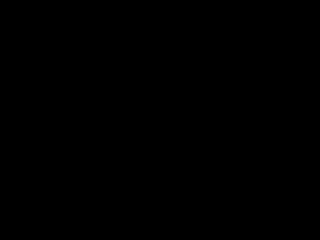

In [26]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data  # 创建模型和数据
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels  # 创建渲染器，渲染并显示像素
with mujoco.Renderer(model) as renderer:
    media.show_image(renderer.render())

""

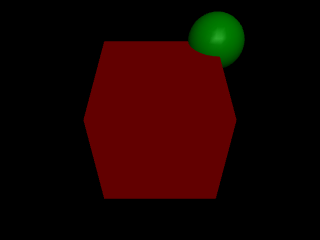

In [27]:
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)  # void mj_forward(const mjModel* m, mjData* d);:正向运动学：与mj_step相同，但不进行时间积分
    renderer.update_scene(data)  # update_scene:更新用于渲染的几何体

    media.show_image(renderer.render())

""

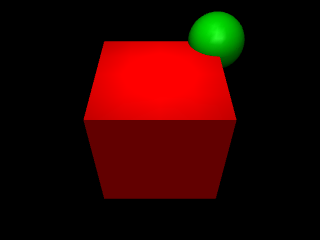

In [28]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>  <!--  -->
    <!-- <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/> -->
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    media.show_image(renderer.render())

""

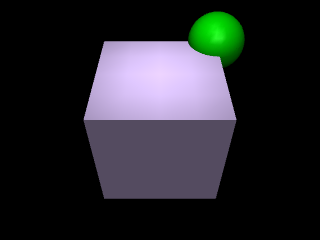

In [29]:
# Run this cell multiple times for different colors  # 对于不同颜色，多次运行此单元格
model.geom('red_box').rgba[:3] = np.random.rand(3)  # 更改颜色
with mujoco.Renderer(model) as renderer:
    renderer.update_scene(data)

    media.show_image(renderer.render())

# Simulation 模拟

In [23]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
# void mj_resetData(const mjModel* m, mjData* d);重置数据为默认值
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)


media.show_video(frames, fps=framerate)

In [7]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
# xml = """
# <mujoco>
#   <worldbody>
#     <light name="top" pos="0 0 1"/>
#     <body name="box_and_sphere" euler="0 0 -30">
#       <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
# body/⁠joint (*):该元素创建一个关节；name:关节的名称；type:[free, ball, slide, hinge], “hinge” 关节的类型 hinge:铰链；
# axis:铰链关节的旋转轴和滑动关节的平移方向；pos:关节的位置
#       <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
#       <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
#     </body>
#   </worldbody>
# </mujoco>
# """
# 从 XML 字符串中创建 mujoco 模型
model = mujoco.MjModel.from_xml_string(xml)
# 创建仿真数据
data = mujoco.MjData(model)

# enable joint visualization option:  # 启动关节可视化选项
scene_option = mujoco.MjvOption()
# 开启关节可视化（例如可以看到铰链关节的轴）
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
#mujoco.mjtVisFlag:其元素用于启用/禁用对应模型或装饰元素的显示；mjVIS_JOINT:joint

# 设定模拟持续时间（秒）和帧率
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.  # 模拟并显示视频
frames = []  # 存储每一帧的图像
mujoco.mj_resetData(model, data)  # 重置仿真数据
# 使用Renderer进行渲染
with mujoco.Renderer(model) as renderer:
    # 当仿真时间没达到设定的duration，就持续仿真
    while data.time < duration:
        mujoco.mj_step(model, data)  # 运行一步仿真
        # 计算当前应该保存的帧数
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option)  # 更新场景
            pixels = renderer.render()  # 渲染当前帧的RGB图像
            frames.append(pixels)  #保存当前帧

# 在Jupyter Notebook中显示视频
media.show_video(frames, fps=framerate)

In [8]:
# 物理选项位于
model.opt.timestep
dir(model.opt)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_float_fields',
 '_floatarray_fields',
 '_int_fields',
 '_pybind11_conduit_v1_',
 'apirate',
 'ccd_iterations',
 'ccd_tolerance',
 'cone',
 'density',
 'disableactuator',
 'disableflags',
 'enableflags',
 'gravity',
 'impratio',
 'integrator',
 'iterations',
 'jacobian',
 'ls_iterations',
 'ls_tolerance',
 'magnetic',
 'noslip_iterations',
 'noslip_tolerance',
 'o_friction',
 'o_margin',
 'o_solimp',
 'o_solref',
 'sdf_initpoints',
 'sdf_iterations',
 'solver',
 'timestep',
 'tolerance',
 'viscosity',
 'wind']

In [9]:
# 让我们翻转重力并重新渲染
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

# Simulate and display video.  # 仿真并显示视频
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option)
            pixels = renderer.render()
            # 确保是 uint8 格式（0~255）
            if pixels.dtype != np.uint8:
                pixels = (pixels * 255).astype(np.uint8)
            frames.append(pixels)

media.show_video(frames, fps=60)

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


### Understanding Degrees of Freedom 理解自由度

In [10]:
print('Total number of DoFs in the model:', model.nv)  # number of degrees of freedom = dim(qvel)
print('Generalized positions:', data.qpos)  # position (nq x 1)
print('Generalized velocities:', data.qvel)  # velocity (nv x 1)

Total number of DoFs in the model: 1
Generalized positions: [1.392]
Generalized velocities: [-3.79]
